## Import Essential Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Install kaggle for loading dataset

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alirezabinayiaan","key":"315664be5f87443f896b38b2d6cd2ac8"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download sanikamal/horses-or-humans-dataset

 99% 305M/307M [00:16<00:00, 21.2MB/s]
100% 307M/307M [00:16<00:00, 19.1MB/s]


In [7]:
!ls

horses-or-humans-dataset.zip  kaggle.json  sample_data


## Unzip Dataset

In [8]:
!unzip -xq horses-or-humans-dataset.zip

## Data Augmentation

In this section we will discuss about data augmentation. for that we can do rotation, shift height and width, zooming and  etc on training data. 

For test data We just normalize them.

In [9]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/horse-or-human/train'
validation_dir = '/content/horse-or-human/validation'

train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 40,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

If you have more than 2 classes, assign class_mode to categorical 

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (160,160))

test_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (160,160))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


As you can see We just have 1027 images for 2 classes. If We train our neural network with this number of images, our result will be not good.

## plot an image

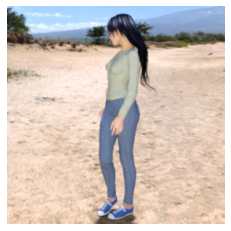

In [11]:
img = cv2.imread('/content/horse-or-human/train/humans/human01-00.png')[:,:,::-1]
img = np.expand_dims(img, axis=0)
plt.imshow(img[0])
plt.axis('off')
plt.show()

## Let's see what does data augmentation do?

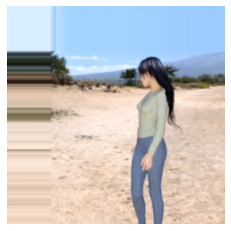

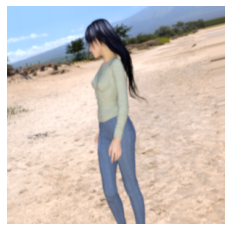

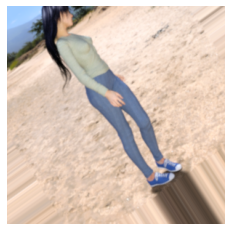

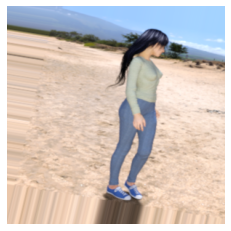

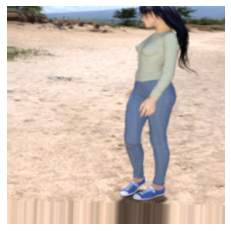

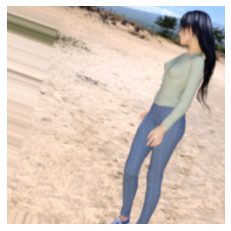

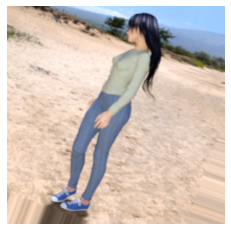

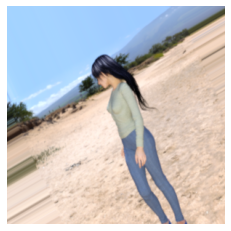

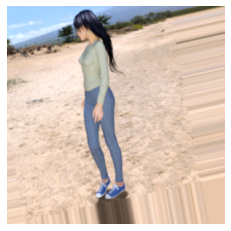

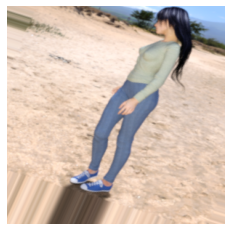

In [12]:
i = 0
for batch in train_datagen.flow(img, batch_size=1):
  plt.imshow(batch[0])
  plt.axis('off')
  plt.show()
  i += 1
  if i == 10:
    break

## Transfer Learning

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast computing and time resources required to develop neural network models on these problems and from the huge jumps in the skill that they provide on related problems.

### Import MobileNet Version2 Model

In [13]:
from keras.applications import MobileNetV2
# BackBone
pretrained_model = MobileNetV2(
    input_shape = (160, 160, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
)

9406464/9406464 [==============================] - 2s 0us/step


### Summary of MobileNetV2

In [14]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Plot MobileNetV2

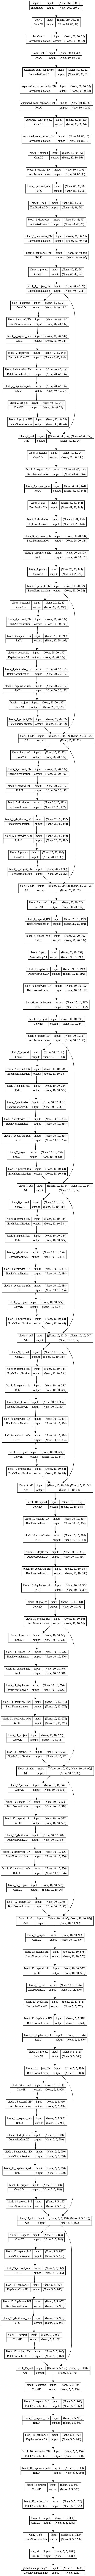

In [15]:
from keras import utils
utils.plot_model(pretrained_model, show_shapes=True, show_layer_names=True)

In [16]:
for layer in pretrained_model.layers:
  layer.trainable = False

In [17]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Get Last layer of MobileNetV2 Model 

#### With name

In [18]:
pretrained_model.get_layer('global_max_pooling2d')

#### With index

In [19]:
last_layer = pretrained_model.get_layer(index=-1)

### Get Output of Last Layer of MobileNetV2 Model

In [20]:
last_layer_output = last_layer.output

### Develop MobileNetV2 Model

In [21]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Dropout

x = Flatten()(last_layer_output)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(units=1, activation='sigmoid', name='FinalOutput')(x)

model = Model(inputs=pretrained_model.input, outputs=output)

### Compile Model and Fit Model

As you can see, We use ModelCheckpoint to save our best model according to the val_loss value.

In [22]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


#Model_Checkpoint
checkpoint_path = '/content/model/best.h5'

model_calback = ModelCheckpoint(filepath=checkpoint_path,
                                monitor='val_loss',
                                verbose=2,
                                save_best_only = True,
                                )
history = model.fit(train_generator, epochs=5, verbose=2, validation_data=test_generator, callbacks=[model_calback])

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.00212, saving model to /content/model/best.h5
17/17 - 23s - loss: 0.2926 - accuracy: 0.8919 - val_loss: 0.0021 - val_accuracy: 1.0000 - 23s/epoch - 1s/step
Epoch 2/5

Epoch 2: val_loss improved from 0.00212 to 0.00080, saving model to /content/model/best.h5
17/17 - 12s - loss: 0.0396 - accuracy: 0.9844 - val_loss: 8.0008e-04 - val_accuracy: 1.0000 - 12s/epoch - 725ms/step
Epoch 3/5

Epoch 3: val_loss improved from 0.00080 to 0.00073, saving model to /content/model/best.h5
17/17 - 12s - loss: 0.0275 - accuracy: 0.9922 - val_loss: 7.2856e-04 - val_accuracy: 1.0000 - 12s/epoch - 731ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.00073
17/17 - 15s - loss: 0.0257 - accuracy: 0.9912 - val_loss: 0.0013 - val_accuracy: 1.0000 - 15s/epoch - 873ms/step
Epoch 5/5

Epoch 5: val_loss improved from 0.00073 to 0.00042, saving model to /content/model/best.h5
17/17 - 16s - loss: 0.0160 - accuracy: 0.9951 - val_loss: 4.1544e-04 - val_accura

### Plot Train and Test Accuracy Also Their Losses

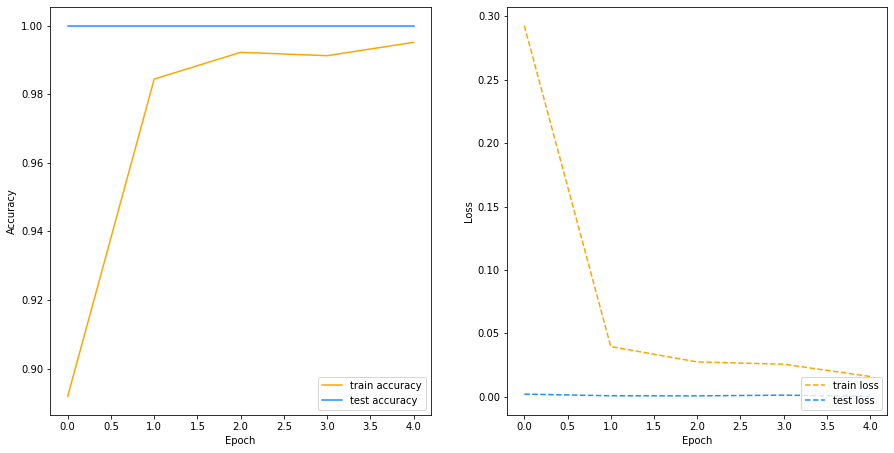

In [23]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],
         label='train accuracy',
         c='orange', ls='-')
plt.plot(history.history['val_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'],
         label='train loss',
         c='orange', ls='--')
plt.plot(history.history['val_loss'],
         label='test loss',
         c='dodgerblue', ls='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

### Measure Accuracy

In [24]:
loss, accuracy = model.evaluate(test_generator)
print('Accuracy: %.2f' % (accuracy*100))

4/4 [==============================] - 1s 210ms/step - loss: 4.1544e-04 - accuracy: 1.0000
Accuracy: 100.00


### Predict Model


In [25]:
pred = model.predict(test_generator)

4/4 [==============================] - 1s 186ms/step
